# III - Vehicle Routing: A Metaheuristic Case Study.

### Problem Definition
We consider a real-world logistics challenge: the Vehicle Routing Problem (VRP). In VRP a fleet of vehicles must deliver goods from a depot to a set of geographically dispersed customers

> - Travelling Salesman Problem (TSP): Given a single vehicle, find the minimum-cost tour that visits each customer exactly once and returns to the depot.
> - Vehicle Routing Problem (VRP): A generalization of the TSP in which multiple vehicles are available; customers must be partitioned among vehicles, and each vehicle performs a route starting and ending at the depot, subject to constraints such as vehicle capacity.
> - Vehicle Routing Problem with Time Windows (VRPTW): An extension of the VRP where each customer must be serviced within a specified time interval, and vehicle routes must respect both capacity constraints and time-window feasibility.


### Formulation
We know: 
* The demand (quantity required) of each customer
* The travel cost (or distance/time) between every pair of locations (customers and depot)
* The number of available vehicles
* The capacity of each vehicle
* A time window for each customer $i$, denoted by $[a_i, b_i]$

We must determine which customers are assigned to each vehicle and the order in which they are served, so as to minimize the total routing cost while satisfying all capacity and time-window constraints.

#### Objective Function
- Minimize total travel cost: $\min \sum_{i,j} c_{ij} \sum_k x_{ijk}$

#### Decision Variables
- $x_{ijk} = 1$ if vehicle $k$ travels directly from $i$ to $j$, $0$ otherwise  
- $T_{ik}$ = service start time of vehicle $k$ at customer $i$

#### Parameters
- $c_{ij}$ = travel cost from $i$ to $j$  
- $t_{ij}$ = travel time from $i$ to $j$  
- $q_i$ = demand of customer $i$  
- $Q_k$ = capacity of vehicle $k$  
- $[a_i, b_i]$ = time window of customer $i$  
- $s_i$ = service time at customer $i$ (assumed 0 in this case-study)  
- $M$ = sufficiently large constant  

### Constraints
- Exactly one vehicle enters each customer (except depot): $\sum_i \sum_k x_{ijk} = 1 \;\forall j \neq \text{depot}$
- Exactly one vehicle leaves each customer (except depot): $\sum_j \sum_k x_{ijk} = 1 \;\forall i \neq \text{depot}$
- Flow conservation (same vehicle enters and leaves): $\sum_i x_{ihk} - \sum_j x_{hjk} = 0 \;\forall h,k$
- Vehicle capacity: $\sum_i q_i \sum_j x_{ijk} \le Q_k \;\forall k$
- Subtour elimination (Prevent disconnected cycles that do not include the depot): $\sum_{i,j \in S} x_{ijk} \le |S| - 1 \;\forall S \subseteq N,\; S \neq \emptyset,\; \forall k$
- Service must start within the allowed time window: $a_i \le T_{ik} \le b_i \;\forall i \neq \text{depot},\forall k$
- Time consistency along routes: $T_{jk} \ge T_{ik} + s_i + t_{ij} - M(1 - x_{ijk}) \;\forall i,j,k$


> M is a large constant used in Big-M constraints to turn constraints on or off depending on a binary decision variable.

This problem is combinatorial and non-convex, it generalizes the Traveling Salesman Problem and is therefore NP-hard (i.e. solution time grows exponentially with problem size). 

* Binary routing variables: The decision variables  $x_{ijk} \in \{0,1\}$
make the Vehicle Routing Problem with Time Windows (VRPTW) a mixed-integer optimization problem. Each variable indicates whether vehicle \( k \) travels directly from customer \( i \) to customer \( j \). There is no concept of a fractional route or “half a vehicle,” unlike continuous flow variables in linear programming. 

* Exponential combinations: Assigning $n$ customers to $m$ vehicles and determining the service sequence for each vehicle leads to a factorial / exponential growth in the number of possible solutions. Even for moderately sized instances, the number of feasible routing combinations is astronomically large.

This combinatorial explosion is the fundamental reason why exact solution methods scale poorly and why heuristic and metaheuristic approaches are commonly used in practice.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import time

In [2]:
#!pip install ortools
#!pip install python-tsp

In [3]:
from python_tsp.exact import solve_tsp_dynamic_programming

In [4]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

## Data Source

For our case-study we use a benchmark VRPTW dataset based on the [classical Solomon instances](https://www.sintef.no/projectweb/top/vrptw/100-customers/). Specifically, we utilize the extended Multi-Time-Window VRP dataset recently published on [Zenodo](https://zenodo.org/records/15296114), which augments Solomon’s problems with multiple time windows for each customer. This provides realistic distance coordinates, demands,
and time-window constraints for a multi-vehicle delivery scenario. 

In [13]:
df_raw = pd.read_csv('data/multiple time window VRP dataset/multiple time window VRP dataset/data/solomon/C101_MTW.csv')

# randomly select k customers along with the depot (CUST_NO 0)

k = 19
df = df_raw.sample(n=k, random_state=1).reset_index(drop=True)
df = pd.concat([pd.DataFrame([df_raw.iloc[0]]), df]).reset_index(drop=True)


print(len(df))
#df.head()
#print(df.columns)

20


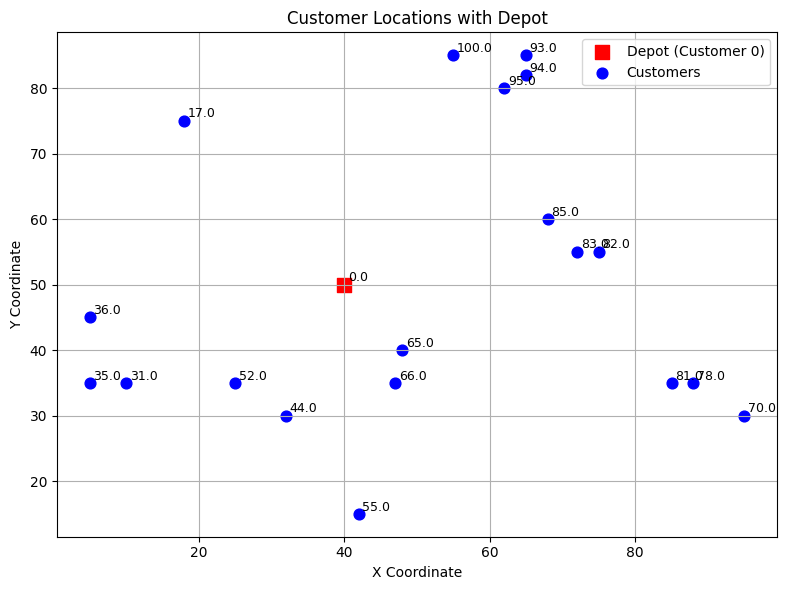

In [14]:
depot = df[df['CUST_NO'] == 0]
customers = df[df['CUST_NO'] != 0]

# Create the plot
plt.figure(figsize=(8, 6))

# Plot depot with red square
plt.scatter(depot['XCOORD'], depot['YCOORD'], color='red', marker='s', s=100, label='Depot (Customer 0)')

# Plot other customers with blue circles
plt.scatter(customers['XCOORD'], customers['YCOORD'], color='blue', marker='o', s=60, label='Customers')

# Annotate all points with their customer number
for _, row in df.iterrows():
    plt.text(row['XCOORD'] + 0.5, row['YCOORD'] + 0.5, str(row['CUST_NO']), fontsize=9)

# Set plot labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Customer Locations with Depot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


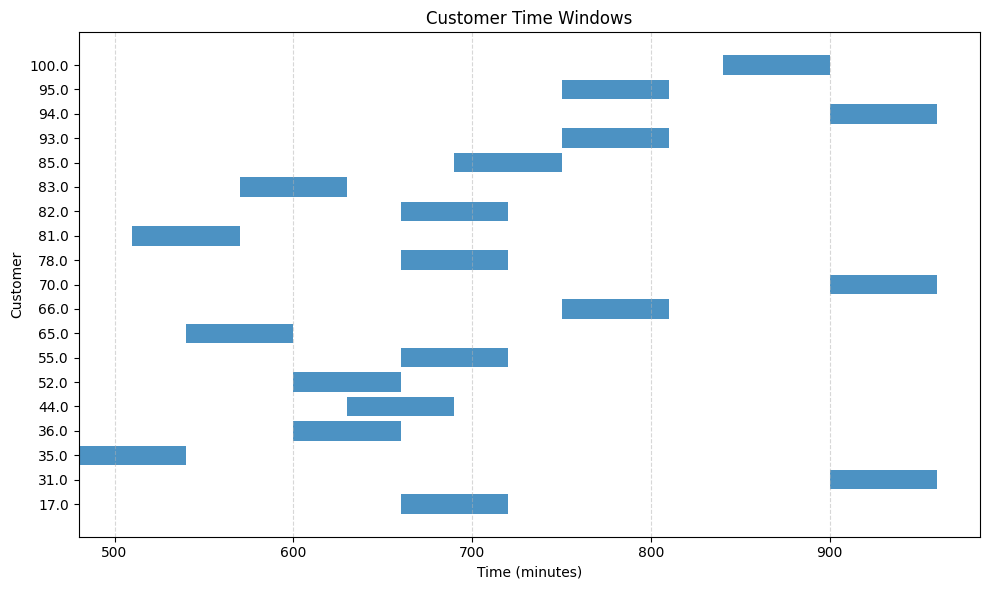

In [15]:
# sort customers
df_plot = df.sort_values("CUST_NO")
# remove 0 customer number
df_plot = df_plot[df_plot["CUST_NO"] != 0]
# y positions
y_pos = range(len(df_plot))

# time window lengths
window_length = df_plot["DUE_TIME_1"] - df_plot["READY_TIME_1"]

plt.figure(figsize=(10, 6))

# horizontal bars
plt.barh(
    y_pos,
    window_length,
    left=df_plot["READY_TIME_1"],
    alpha=0.8
)

# y-axis labels
plt.yticks(y_pos, df_plot["CUST_NO"])

# labels and title
plt.xlabel("Time (minutes)")
plt.ylabel("Customer")
plt.title("Customer Time Windows")

plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [16]:
depot_index = int(df.index[df['CUST_NO'] == 0][0])

# Compute Euclidean distance matrix
coords_array = df[['XCOORD','YCOORD']].to_numpy()
dist_matrix = np.sqrt(((coords_array[:,None,:] - coords_array[None,:,:])**2).sum(axis=2))

In [17]:
scale = 1
scaled_dist_matrix = np.rint(dist_matrix * scale).astype(int)

## Scenario 1 -  Traveling Salesman Problem
In this scenario, a single vehicle starts from a depot, visits all customers exactly once, and returns to the depot. The objective is to minimize the total travel distance.

- One vehicle
- No capacity constraints
- No time window constraints

In [18]:
## Data Model
data = {}
data['distance_matrix_scaled'] = scaled_dist_matrix
data['num_vehicles'] = 1
data['depot'] = depot_index

### Option 1 - Exact Solution
We will first approach this using this problem using an exact dynamic programming algorithm (Held–Karp). The method is exact and guarantees optimality, but it is slow because it must enumerate all $2^𝑛$ subsets of customers, leading to exponential time complexity

In [19]:
D = np.array(scaled_dist_matrix)
# Reorder so the depot becomes node 0 (python-tsp assumes start at 0)
n = D.shape[0]
perm = [depot_index] + [i for i in range(n) if i != depot_index]
D2 = D[np.ix_(perm, perm)]
# Exact TSP (cycle). Returns permutation starting at 0 and the optimal tour length.

t_start = time.perf_counter()
# Exact TSP (Held–Karp)
_, total_distance = solve_tsp_dynamic_programming(D2)
t_end = time.perf_counter()
print(f"Exact TSP (Held–Karp) took {t_end - t_start:.4f} seconds")
print("Optimal total distance:", total_distance)

Exact TSP (Held–Karp) took 82.1020 seconds
Optimal total distance: 305


### Option 2 – Metaheuristic Solution
To overcome the computational limitations of exact methods, we employ a metaheuristic approach using Google OR-Tools. The Traveling Salesman Problem is modeled as a weighted graph, and a feasible tour is first constructed using a greedy heuristic (Path Cheapest Arc), which incrementally selects the lowest-cost admissible edges. This initial solution is then refined through local search techniques that explore neighboring solutions to reduce total travel cost. While this approach does not guarantee optimality, it efficiently produces high-quality, near-optimal solutions and scales well to large problem instances where exact optimization is impractical.

In [20]:
# Create the routing model
# The pywrapcp.RoutingIndexManager is responsible for translating between external 
# node indices (which you use in your problem definition) and internal solver indices.
# The inputs to RoutingIndexManager are:
# - The number of rows of the distance matrix, which is the number of locations (including the depot).
# - The number of vehicles in the problem.
# - The node corresponding to the depot.

manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix_scaled"]), data["num_vehicles"], data["depot"]
)
routing = pywrapcp.RoutingModel(manager)

# Create the distance callback
# To use the routing solver, you need to create a distance (or transit) callback: 
# a function that takes any pair of locations and returns the distance between them.
# The easiest way to do this is using the distance matrix.

def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data["distance_matrix_scaled"][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Set the cost of travel
# The arc cost evaluator tells the solver how to calculate the cost of travel 
# between any two locations — in other words, the cost of the edge (or arc) 
# joining them in the graph for the problem. The following code sets the arc cost 
# evaluator.

routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Set search parameters
# The code sets the first solution strategy to PATH_CHEAPEST_ARC, 
# which creates an initial route for the solver by repeatedly adding edges 
# with the least weight that don't lead to a previously visited node 
# (other than the depot).

search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)


In [21]:
# Solution Printer
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()} miles")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    plan_output += f"Route distance: {route_distance}miles\n"
    print(plan_output)


In [22]:
t_start = time.perf_counter()
solution = routing.SolveWithParameters(search_parameters)
t_end = time.perf_counter()
print(f"OR Tools took {t_end - t_start:.4f} seconds")

if solution:
    print_solution(manager, routing, solution)

OR Tools took 0.0358 seconds
Objective: 305 miles
Route for vehicle 0:
 0 -> 15 -> 17 -> 7 -> 12 -> 10 -> 13 -> 16 -> 5 -> 3 -> 4 -> 14 -> 1 -> 11 -> 6 -> 8 -> 9 -> 18 -> 2 -> 19 -> 0
Route distance: 305miles



In [23]:
def plot_tsp_route_ortools(df, manager, routing, solution,
                          vehicle_id=0,
                          distance_matrix=None,   # e.g., data['distance_matrix_scaled'] or data['distance_matrix']
                          scale=1,                # e.g., 1000 if using scaled costs, else 1
                          x_col="XCOORD", y_col="YCOORD", node_col="CUST_NO",
                          show_labels=True):
    """
    One-stop function:
      1) Extracts the OR-Tools route for `vehicle_id`
      2) Plots points + arrows
      3) Computes total route distance using your EXISTING distance matrix
         (so it matches what OR-Tools optimized)

    Notes:
      - Assumes IndexToNode outputs indices aligned with df row order (df reset_index recommended).
      - distance_matrix should be the same one you used for costs, typically scaled.
    """
    if solution is None:
        raise ValueError("No solution found (solution is None).")

    if distance_matrix is None:
        raise ValueError("Please pass distance_matrix (e.g., data['distance_matrix_scaled']).")

    xs = df[x_col].to_numpy()
    ys = df[y_col].to_numpy()

    # --- Extract route nodes (including end depot) ---
    index = routing.Start(vehicle_id)
    route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
        index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))

    # --- Compute total distance from existing matrix ---
    total_cost = 0
    for a, b in zip(route[:-1], route[1:]):
        total_cost += int(distance_matrix[a][b])
    total_distance = total_cost / scale

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    plt.scatter(xs, ys)

    # depot highlight (assumes depot is route[0])
    depot_node = route[0]
    plt.scatter([xs[depot_node]], [ys[depot_node]], s=140, marker="s", label="Depot")

    # labels
    if show_labels:
        labels = df[node_col].to_numpy() if node_col in df.columns else np.arange(len(df))
        for i in range(len(df)):
            plt.text(xs[i], ys[i], str(labels[i]), fontsize=9, ha="left", va="bottom")

    # arrows
    for a, b in zip(route[:-1], route[1:]):
        plt.annotate(
            "",
            xy=(xs[b], ys[b]),
            xytext=(xs[a], ys[a]),
            arrowprops=dict(arrowstyle="->", lw=1),
        )

    plt.title(f"TSP (vehicle {vehicle_id}) | Total distance = {total_distance:.2f}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()

    return route, total_distance


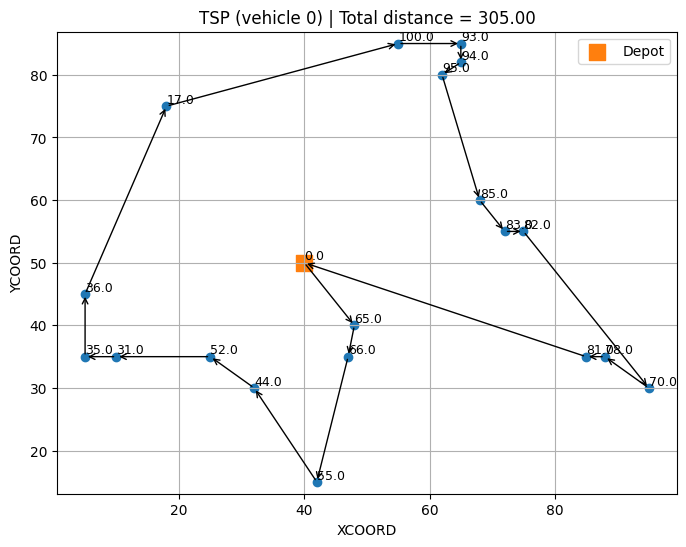

In [24]:
route, dist = plot_tsp_route_ortools(df, manager, 
                                     routing, solution,
                                     vehicle_id=0,
                                     distance_matrix=data['distance_matrix_scaled'],
                                     scale=1)

## Scenario 2 – Capacitated Vehicle Routing Problem

In this scenario, there are K vehicles available at a central depot. Each vehicle has a maximum load capacity, and customer demands must be delivered without exceeding that capacity. The objective is to design a set of routes that minimizes total travel cost (or distance) while ensuring all customer demands are served.

- K vehicles
- Capacity constraints (total demand on each route must not exceed vehicle capacity)
- No time window constraints on customer visits

In [25]:
## Data Model

K = 4
vehicle_capacity = int(1.2*np.ceil(sum(df['DEMAND']) / K))
print(vehicle_capacity)
data = {}
data['distance_matrix_scaled'] = scaled_dist_matrix
data['num_vehicles'] = K
data['demands'] = df['DEMAND'].tolist()
data['vehicle_capacities'] = [vehicle_capacity]*K
data['depot'] = depot_index

105


In [26]:
# Create the routing model
manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix_scaled"]), data["num_vehicles"], data["depot"]
)

routing = pywrapcp.RoutingModel(manager)

# Create the distance callback
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(data["distance_matrix_scaled"][from_node][to_node])

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Capacity constraint.
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return int(data["demands"][from_node])

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
)

# Set search parameters
# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.FromSeconds(1)

In [27]:
solution = routing.SolveWithParameters(search_parameters)

In [28]:
def plot_cvrp_routes_ortools(df, manager, routing, solution,
                            distance_matrix=None,
                            scale=1,
                            x_col="XCOORD", y_col="YCOORD", node_col="CUST_NO",
                            show_labels=True,
                            show_arrows=True):
    """
    CVRP visualizer with:
      - per-vehicle colored routes
      - per-vehicle distance + load in legend
      - total distance + total load in title
    """
    if solution is None:
        raise ValueError("No solution found.")
    if distance_matrix is None:
        raise ValueError("Please pass distance_matrix.")

    xs = df[x_col].to_numpy()
    ys = df[y_col].to_numpy()

    labels = None
    if show_labels:
        labels = df[node_col].to_numpy() if node_col in df.columns else np.arange(len(df))

    depot_node = manager.IndexToNode(routing.Start(0))

    # Capacity dimension (if present)
    try:
        cap_dim = routing.GetDimensionOrDie("Capacity")
    except Exception:
        cap_dim = None

    routes = {}
    per_vehicle_distance = {}
    per_vehicle_load = {}

    total_cost = 0
    total_load = 0

    # --- Extract routes, distance, load ---
    for v in range(routing.vehicles()):
        start_index = routing.Start(v)
        if solution.Value(routing.NextVar(start_index)) == routing.End(v):
            continue

        index = start_index
        route = [manager.IndexToNode(index)]
        route_cost = 0

        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            next_index = solution.Value(routing.NextVar(index))
            next_node = manager.IndexToNode(next_index)

            route.append(next_node)
            route_cost += int(distance_matrix[node][next_node])
            index = next_index

        routes[v] = route
        per_vehicle_distance[v] = route_cost / scale
        total_cost += route_cost

        if cap_dim is not None:
            load = solution.Value(cap_dim.CumulVar(routing.End(v)))
        else:
            load = 0

        per_vehicle_load[v] = load
        total_load += load

    total_distance = total_cost / scale

    # --- Plot base points ---
    plt.figure(figsize=(9, 7))
    plt.scatter(xs, ys, label="Customers")
    plt.scatter([xs[depot_node]], [ys[depot_node]],
                s=180, marker="s", label="Depot")

    if show_labels:
        for i in range(len(df)):
            plt.text(xs[i], ys[i], str(labels[i]),
                     fontsize=9, ha="left", va="bottom")

    # --- Colors ---
    used_vehicles = list(routes.keys())
    cmap = plt.get_cmap("tab10") if len(used_vehicles) <= 10 else plt.get_cmap("tab20")

    # --- Draw routes ---
    for idx, v in enumerate(used_vehicles):
        route = routes[v]
        color = cmap(idx % cmap.N)

        for a, b in zip(route[:-1], route[1:]):
            x1, y1 = xs[a], ys[a]
            x2, y2 = xs[b], ys[b]

            plt.plot([x1, x2], [y1, y2], color=color, lw=1.8)

            if show_arrows:
                plt.annotate(
                    "",
                    xy=(x2, y2),
                    xytext=(x1, y1),
                    arrowprops=dict(arrowstyle="->", lw=1.8, color=color),
                )

        # legend entry
        plt.plot(
            [],
            [],
            color=color,
            lw=3,
            label=f"Vehicle {v} | dist={per_vehicle_distance[v]:.2f}, load={per_vehicle_load[v]}"
        )

    plt.title(
        f"CVRP Routes | Vehicles used = {len(routes)} | "
        f"Total distance = {total_distance:.2f} | Total load = {total_load}"
    )
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()

    return routes, total_distance, per_vehicle_distance, per_vehicle_load


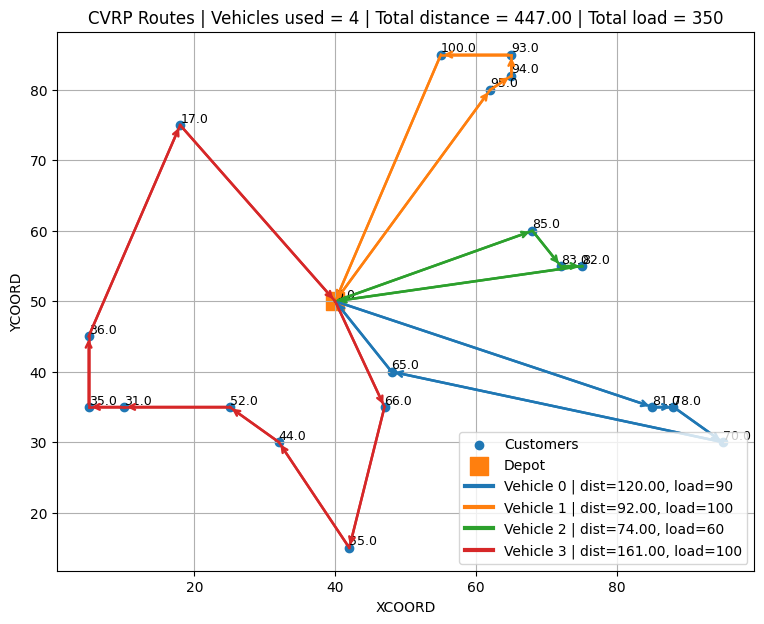

Total distance: 447.0
Per-vehicle: {0: 120.0, 1: 92.0, 2: 74.0, 3: 161.0}


In [29]:
routes, total_dist, per_v_dist, per_v_load  = plot_cvrp_routes_ortools(
    df, manager, routing, solution,
    distance_matrix=data['distance_matrix_scaled'],
    scale=1,           
    show_labels=True,
    show_arrows=True
)
print("Total distance:", total_dist)
print("Per-vehicle:", per_v_dist)

## Scenario 3 – Vehicle Routing with Time Windows

In this scenario, a fleet of $K$ vehicles is available at a central depot. Each vehicle has a fixed load capacity, and customer demands must be delivered without exceeding vehicle capacity constraints. Each customer must also be visited within a specified time window.

The objective is to design a set of vehicle routes that minimizes total travel cost (or distance) while ensuring that all customer demands are satisfied and all operational constraints are respected.

- $K$ vehicles starting and ending at a central depot  
- Capacity constraints: total demand served on each route must not exceed vehicle capacity  
- Time window constraints on customer service times  


In [30]:
## Data Model

K = 4

vehicle_capacity = int(1.2*np.ceil(sum(df['DEMAND']) / K))
print(vehicle_capacity)
data = {}
data['distance_matrix_scaled'] = scaled_dist_matrix
data['num_vehicles'] = K
data['demands'] = df['DEMAND'].tolist()
#data['vehicle_capacities'] = [vehicle_capacity]*K
data['time_windows'] = list(zip(df['READY_TIME_1'], df['DUE_TIME_1']))  
data['depot'] = depot_index

105
